In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd 
data = pd.read_pickle("/content/gdrive/MyDrive/TICNN_Implementation/TICNN/final_text_df.pkl")

In [4]:
import numpy as np

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
#import swifter

from matplotlib import pyplot as plt
from matplotlib import style
#Nicer style
style.use('seaborn')
import seaborn as sns

from tensorflow import keras as k

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


df=pd.DataFrame()
data["text"] = (pad_sequences(data["text"], maxlen=400,padding="post", truncating="post")).tolist()
data["title"] = pad_sequences(data["title"], maxlen=400,padding="post", truncating="post").tolist()

In [6]:
from pathlib import Path
import numpy as np
from keras.preprocessing.text import Tokenizer

def load_glove(url):
    f = open(url.absolute())
    embeddings_index = dict()
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

GLOVE_URL = Path("/content/gdrive/MyDrive/TICNN_Implementation/TICNN/glove.6B.100d.txt")
glove = load_glove(GLOVE_URL)
t = Tokenizer()
t.fit_on_texts(glove.keys())
vocab_size = len(t.word_index) + 1

In [7]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    data[['text', 'title']], data['type'], test_size=0.1, random_state=1)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, random_state=1)

In [9]:
X_train_title = X_train['title']
X_train_content = X_train['text']

X_valid_title = X_valid['title']
X_valid_content = X_valid['text']

X_test_title = X_test['title']
X_test_content = X_test['text']

In [10]:
train_fit = [np.asarray(X_train_title.tolist()), 
             np.asarray(X_train_content.tolist())]

valid_fit = [np.asarray(X_valid_title.tolist()), 
             np.asarray(X_valid_content.tolist())]

test_fit = [np.asarray(X_test_title.tolist()), 
             np.asarray(X_test_content.tolist())]

In [11]:

!pip install scikit-optimize

import skopt

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective

from numpy.random import seed


import tensorflow as tf

import os

     |████████████████████████████████| 102kB 5.0MB/s 


In [12]:
space  = [Real(1e-5, 0.4, name='lr'),
          
          Real(1e-3, 0.1, name='momentum'),
          Real(0.1, 0.3, name='dropout1'),
          Integer(50,100, name='dense1'),
          Integer(20,50, name='dense2'),
          Integer(20,100, name='lstmTitle'),
          Integer(50,300, name='lstmContent')]


@use_named_args(space)
def lstm_model(**params):
    
    x_train = train_fit
    y_train2 = np.array(y_train.tolist())
    
    x_valid = valid_fit
    y_valid2 = np.array(y_valid.tolist())
    
    x_test = test_fit
    y_test2 = np.array(y_test.tolist())

    #Reproducible weights
    seed(50)
    tf.random.set_seed(50)
    k.backend.clear_session()
    
    
    

    #input_title
    title_input = k.layers.Input(shape=(400,), name='title_input')
    inp = k.layers.Embedding(output_dim=100, input_dim=339252, 
                             weights=[embedding_matrix], trainable=False)(title_input)
    x = k.layers.Bidirectional(k.layers.LSTM(params['lstmTitle']))(inp)
    #CudnnLSTM

    #input_content
    content_input = k.layers.Input(shape=(400,), name='content_input')
    inp2 = k.layers.Embedding(output_dim=100, input_dim=339252, 
                             weights=[embedding_matrix], trainable=False)(content_input)
    x2 = k.layers.Bidirectional(k.layers.LSTM(params['lstmContent']))(inp2)
    #CudnnLSTM

    #Merge
    x = k.layers.concatenate([x, x2])


    #Common part
    x = k.layers.Dense(params['dense1'], activation='relu')(x)
    x = k.layers.Dropout(params['dropout1'])(x)
    x = k.layers.Dense(params['dense2'], activation='relu')(x)
    x = k.layers.Dropout(0.2)(x)

    out = k.layers.Dense(1, activation='sigmoid')(x)

    #Build model
    model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

    #model.compile(k.optimizers.SGD(), loss='categorical_crossentropy', metrics=['acc'])
    from keras.optimizers import Adam
    opt = Adam(lr=1e-3, decay=1e-3 / 200)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])      
    out = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=64*8, epochs=30,validation_data=(valid_fit, np.array(y_valid.tolist())))
        
    #Evaluation
    acc = model.evaluate(x=x_test, y=y_test2)
    return -acc[1] #Maximize accuracy

In [13]:
r = skopt.gp_minimize(lstm_model, n_random_starts=3, n_calls=3, dimensions=space)

Epoch 1/30
32/32 [==============================] - 48s 366ms/step - loss: 0.5816 - accuracy: 0.6833 - val_loss: 0.3931 - val_accuracy: 0.8257
Epoch 2/30
32/32 [==============================] - 10s 323ms/step - loss: 0.3739 - accuracy: 0.8406 - val_loss: 0.3288 - val_accuracy: 0.8629
Epoch 3/30
32/32 [==============================] - 10s 325ms/step - loss: 0.3007 - accuracy: 0.8791 - val_loss: 0.2525 - val_accuracy: 0.8979
Epoch 4/30
32/32 [==============================] - 10s 327ms/step - loss: 0.2450 - accuracy: 0.8992 - val_loss: 0.2380 - val_accuracy: 0.8979
Epoch 5/30
32/32 [==============================] - 11s 332ms/step - loss: 0.2098 - accuracy: 0.9160 - val_loss: 0.2223 - val_accuracy: 0.9062
Epoch 6/30
32/32 [==============================] - 11s 330ms/step - loss: 0.1908 - accuracy: 0.9233 - val_loss: 0.2310 - val_accuracy: 0.9007
Epoch 7/30
32/32 [==============================] - 11s 331ms/step - loss: 0.1736 - accuracy: 0.9309 - val_loss: 0.2160 - val_accuracy: 0.9179

In [14]:
print("PARAMETERS (LR/Optimizer): {}  RESULT {}".format(r.x, r.fun))

PARAMETERS (LR/Optimizer): [0.19784571219875324, 0.023580227340484292, 0.15109478475144228, 70, 31, 100, 152]  RESULT -0.9475524425506592


In [18]:
params_lstm = {
    'lr': 0.19784571219875324,
    'momentum':0.023580227340484292,
    'dropout': 0.15109478475144228,
    'dense1': 70,
    'dense2': 31,
    'lstmTitle': 100,
    'lstmContent': 152
}


In [19]:

#Some imports...
import tensorflow as tf
import os

from numpy.random import seed

In [20]:
seed(50)
tf.random.set_seed(50)
k.backend.clear_session()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        [(None, 400)]        0                                            
__________________________________________________________________________________________________
content_input (InputLayer)      [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 100)     33925200    title_input[0][0]                
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 100)     33925200    content_input[0][0]              
______________________________________________________________________________________________

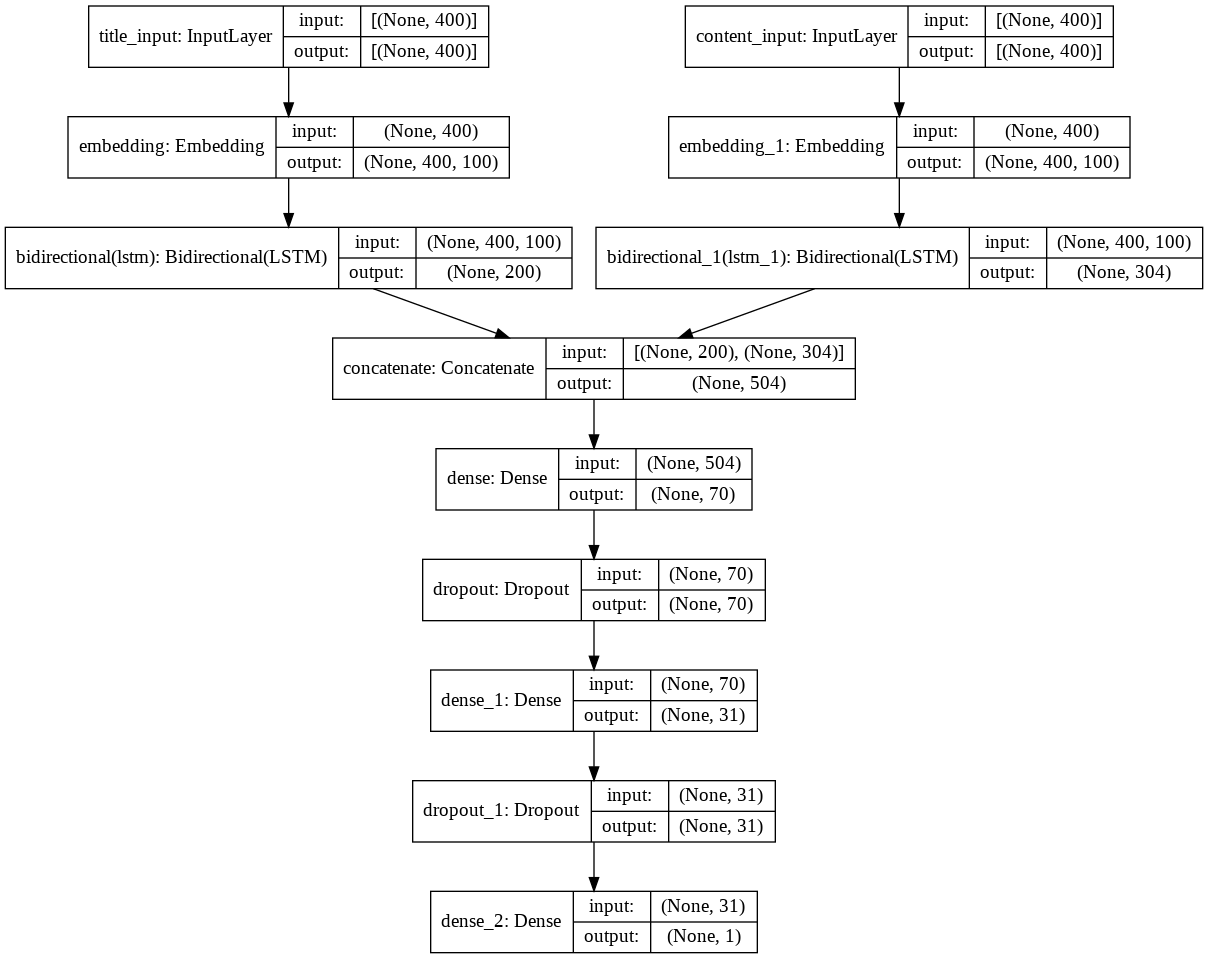

In [21]:
title_input = k.layers.Input(shape=(400,), name='title_input')
inp = k.layers.Embedding(output_dim=100, input_dim=339252, 
                         weights=[embedding_matrix], trainable=False)(title_input)
x = k.layers.Bidirectional(k.layers.LSTM(params_lstm['lstmTitle']))(inp)
#CudnnLSTM
#x = k.layers.Bidirectional(k.layers.CuDNNLSTM(params_lstm['lstmTitle']))(inp)

#input_content
content_input = k.layers.Input(shape=(400,), name='content_input')
inp2 = k.layers.Embedding(output_dim=100, input_dim=339252, 
                         weights=[embedding_matrix], trainable=False)(content_input)
x2 = k.layers.Bidirectional(k.layers.LSTM(params_lstm['lstmContent']))(inp2)
#CudnnLSTM
#x2 = k.layers.Bidirectional(k.layers.CuDNNLSTM(params_lstm['lstmContent']))(inp2)

#Merge
x = k.layers.concatenate([x, x2])


#Common part
x = k.layers.Dense(params_lstm['dense1'], activation='relu')(x)
x = k.layers.Dropout(params_lstm['dropout'])(x)
x = k.layers.Dense(params_lstm['dense2'], activation='relu')(x)
x = k.layers.Dropout(0.2)(x)

out = k.layers.Dense(1, activation='sigmoid')(x)

#Build model
model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

#model.compile(k.optimizers.SGD(lr=params_lstm['lr'], 
#                               momentum=params_lstm['momentum']), 
#                               loss='categorical_crossentropy', metrics=['acc'])

from keras.optimizers import Adam
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True)

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint
#model = tpu_model
hist = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=64*8, epochs=30,
         
                 validation_data=(valid_fit, np.array(y_valid.tolist())))

Epoch 1/30
32/32 [==============================] - 11s 337ms/step - loss: 0.0645 - accuracy: 0.9762 - val_loss: 0.1957 - val_accuracy: 0.9279
Epoch 2/30
32/32 [==============================] - 11s 338ms/step - loss: 0.0516 - accuracy: 0.9825 - val_loss: 0.2110 - val_accuracy: 0.9290
Epoch 3/30
32/32 [==============================] - 11s 340ms/step - loss: 0.0469 - accuracy: 0.9839 - val_loss: 0.2584 - val_accuracy: 0.9295
Epoch 4/30
32/32 [==============================] - 11s 338ms/step - loss: 0.0464 - accuracy: 0.9823 - val_loss: 0.2388 - val_accuracy: 0.9295
Epoch 5/30
32/32 [==============================] - 11s 341ms/step - loss: 0.0347 - accuracy: 0.9873 - val_loss: 0.2175 - val_accuracy: 0.9334
Epoch 6/30
32/32 [==============================] - 11s 341ms/step - loss: 0.0309 - accuracy: 0.9904 - val_loss: 0.2602 - val_accuracy: 0.9273
Epoch 7/30
32/32 [==============================] - 11s 342ms/step - loss: 0.0206 - accuracy: 0.9942 - val_loss: 0.2525 - val_accuracy: 0.9356

In [23]:
model.save("model.h5")